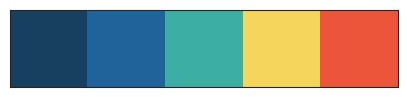

In [1]:
# Import the required packages
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style("white")
from matplotlib.ticker import FuncFormatter

from sklearn.preprocessing import StandardScaler

# Plotly
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go

from scipy.optimize import minimize

import yfinance as yf
import fredapi as fa
from datetime import datetime, timedelta

### Define the colour scheme
c1 = "#173f5f"
c2 = "#20639b"
c3 = "#3caea3"
c4 = "#f6d55c"
c5 = "#ed553b"

custom_palette = [c1, c2, c3, c4, c5]
sns.palplot(sns.color_palette(custom_palette))

# User defined function
def summary(rates):
    summ = pd.DataFrame(rates.dtypes, columns=['data type'])
    summ['#total'] = rates.shape[0]
    summ['#missing'] = rates.isnull().sum().values 
    summ['%missing'] = rates.isnull().sum().values / len(rates)* 100
    summ['#unique'] = rates.nunique().values
    summ['#duplicates'] = summ['#total'] - summ['#unique']
    desc = pd.DataFrame(rates.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    return summ

### Data Processing

In [2]:
# Calculation data date
start_date = datetime.today() - timedelta(days=366)
end_date = datetime.today()

In [3]:
api_key = # Personal API key can be download in FRED website for free
fred_endpoint = "https://api.stlouisfed.org/fred"
fred = fa.Fred(api_key)

In [4]:
series_ids = ['DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 
              'DGS7', 'DGS10', 'DGS20', 'DGS30']

In [5]:
rates = {}

for series_id in series_ids:
    response = fred.get_series(series_id, 
                               observation_start = start_date, 
                               observation_end = end_date)
    rates[series_id] = response
    
rates = pd.DataFrame.from_dict(rates)

In [6]:
rates.dropna(inplace=True)

In [7]:
# View the data
summary(rates).style.background_gradient(cmap='Blues')

,data type,#total,#missing,%missing,#unique,#duplicates,min,max
DGS3MO,float64,250,0,0.000000,39,211,5.200000,5.630000
DGS6MO,float64,250,0,0.000000,50,200,5.040000,5.610000
DGS1,float64,250,0,0.000000,72,178,4.590000,5.490000
DGS2,float64,250,0,0.000000,94,156,3.750000,5.190000
DGS3,float64,250,0,0.000000,105,145,3.470000,5.030000
DGS5,float64,250,0,0.000000,112,138,3.290000,4.950000
DGS7,float64,250,0,0.000000,120,130,3.320000,5.000000
DGS10,float64,250,0,0.000000,118,132,3.370000,4.980000
DGS20,float64,250,0,0.000000,108,142,3.790000,5.300000
DGS30,float64,250,0,0.000000,107,143,3.700000,5.110000


In [8]:
def plot_rates(rates):
    plot_vars = rates.columns
    
    fig, ax = plt.subplots(figsize=(8,4), ncols=1, nrows=1)
    for var in plot_vars:
        ax.plot(rates.index, rates[var], label=var, lw=0.5)
    ax.set(title='Daily Interest Rate', xlabel='Date', 
           ylabel='Interest Rate (%)')
    fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))
    plt.show()

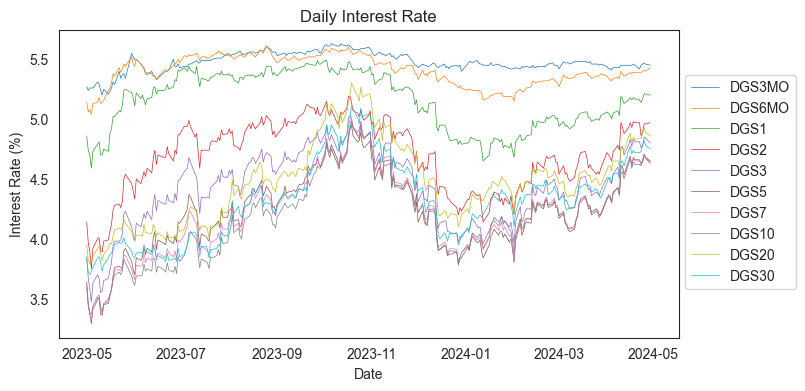

In [9]:
# Plot the daily interest rates
plot_rates(rates)

### Standardising the Data

Standardising the data to normal distribution with a mean of 0 and standard deviation of 1 (y-axis)

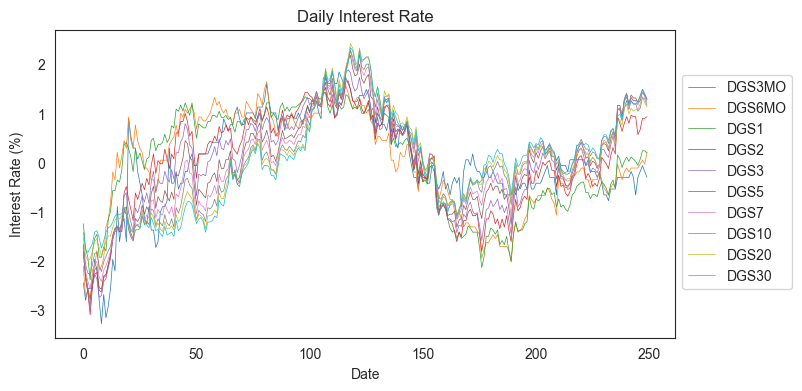

In [10]:
# Create instance of scalar
scaler = StandardScaler()
rates_scaled = pd.DataFrame(scaler.fit_transform(np.array(rates)))
rates_scaled.columns = rates.columns

# Plot the scalared dataset
plot_rates(rates_scaled)

### Compute Covariance Matrix

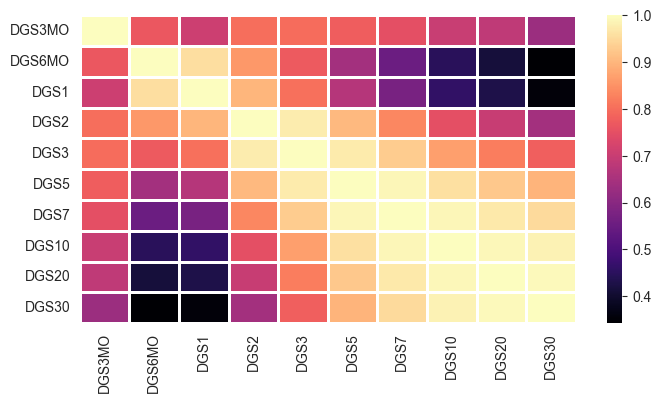

In [11]:
# Compute covariance matrix
fig, ax = plt.subplots(figsize=(8,4))
sns.heatmap(rates_scaled.corr(), cmap='magma', linecolor='white', 
            linewidths=1)
plt.show()

### Eigenvalue and Eigenvector Decomposition

The eigenvectors represent the principal components (the directions of maximum variance) of the covariance matrix. The eigenvalues are their corresponding magnitude. The eigenvector that has the largest corresponding eigenvalue represents the direction of maximum variance. An eigenvector v satisfies the following condition:

Where λ is a scalar and known as the eigenvalue.

In [12]:
cov = np.cov(rates_scaled, rowvar=False)

In [13]:
# Eigenvalue and eigenvectors
eig_values, eig_vectors = np.linalg.eig(cov)

# View the eigenvalues and vectors
print("Eigenvalues:\t", eig_values[0])
print("Eigenvectors:\t", eig_vectors[0])

Eigenvalues:	 8.014736706764678
Eigenvectors:	 [-0.30033077  0.1641569  -0.8865362  -0.26239468  0.15408867  0.018112
 -0.06201994  0.00655605  0.00675891  0.00707333]


### Selecting Principle Components

Now that the eigenpairs have been computed they now need to be sorted based on the magnitude of their eigenvalues. 

In [14]:
# Sort the eigenvectors
idx = np.argsort(eig_values, axis=0)[::-1]
sorted_eig_vectors = eig_vectors[:, idx]

Now that the principal components have been sorted based on the magnitude of their corresponding eigenvalues, it is time to determine how many principal components to select for dimensionality reduction. This can be done by plotting the cumulative sum of the eigenvalues.

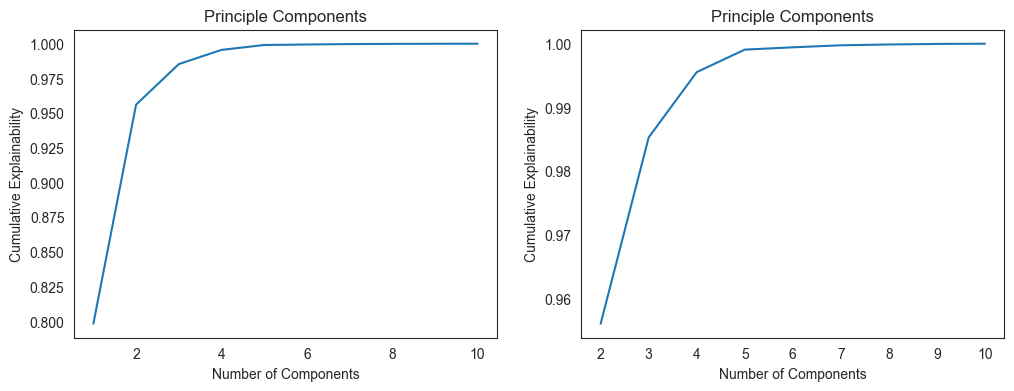

In [15]:
# Cumulative sum of the eigenvalues
cumsum = np.cumsum(eig_values[idx]) / np.sum(eig_values[idx])
xint = range(1, len(cumsum) + 1)

# Plot the explainability by the number of components
fig, ax = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
ax[0].plot(xint, cumsum)
ax[0].set(title='Principle Components', xlabel='Number of Components', 
          ylabel='Cumulative Explainability')

ax[1].plot(xint[1:], cumsum[1:])
ax[1].set(title='Principle Components', xlabel='Number of Components', 
          ylabel='Cumulative Explainability')
plt.show()

From the plots, we can see that over 99% of the variance is captured within the four largest principal components. Therefore, it is acceptable to choose the first four largest principal components to make up the projection matrix.

### Compute the transformation

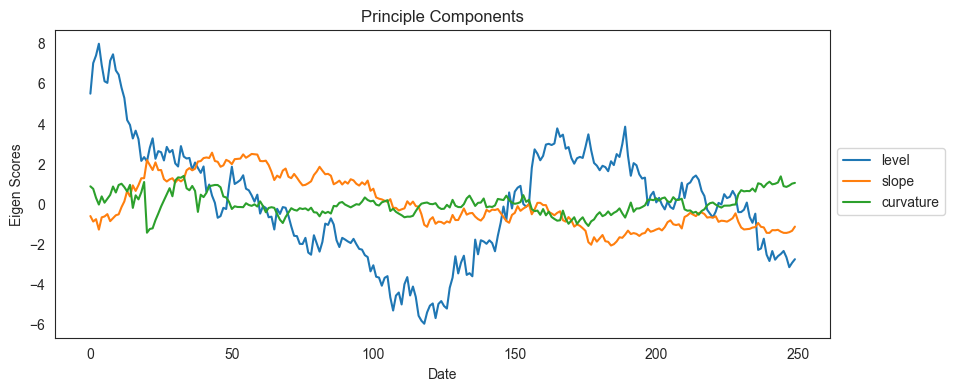

                 PC1       PC2       PC3       PC4
2024-04-16 -2.865293 -1.463536  1.087256 -0.247273
2024-04-17 -2.368311 -1.323470  0.957629 -0.269140
2024-04-18 -2.799138 -1.332800  0.986762 -0.345922
2024-04-19 -2.623856 -1.310138  1.049451 -0.317186
2024-04-22 -2.514573 -1.399585  1.354858 -0.225907
2024-04-23 -2.364117 -1.460754  0.868456 -0.106990
2024-04-24 -2.678147 -1.464107  0.829401 -0.040694
2024-04-25 -3.172745 -1.428206  0.896654 -0.106779
2024-04-26 -2.953885 -1.358003  0.993452 -0.169760
2024-04-29 -2.774582 -1.150204  1.030475 -0.038317


In [16]:
pc_scores = np.dot(rates_scaled, sorted_eig_vectors[:, :4])

fig, ax = plt.subplots(figsize=(10,4), ncols=1, nrows=1)
for i, pca in enumerate(['level','slope','curvature']):
    ax.plot(pc_scores[:,i], label=pca)
ax.set(title='Principle Components', xlabel='Date', 
       ylabel='Eigen Scores')
fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))
plt.show()

rates_pca = pd.DataFrame(pc_scores, columns=['PC1','PC2','PC3','PC4'])
rates_pca.index = rates.index

print(rates_pca.tail(10))

### Interest Rate Recomposition

Principle Component Score Array Shape:	 (250, 4)


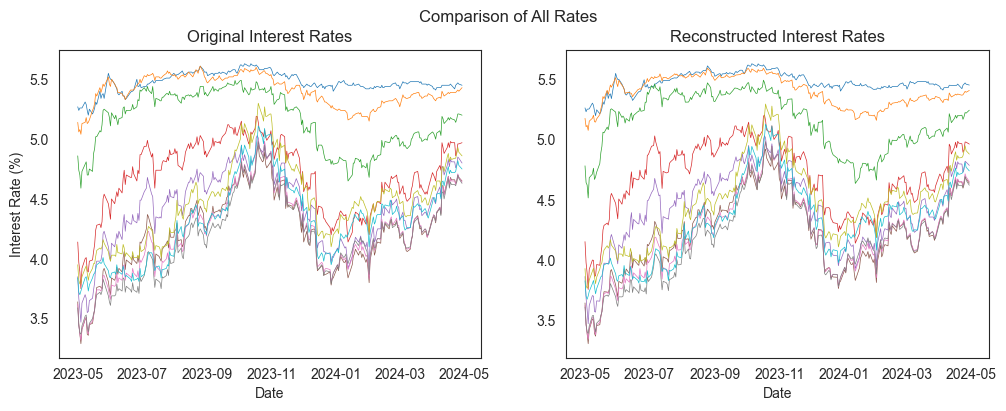

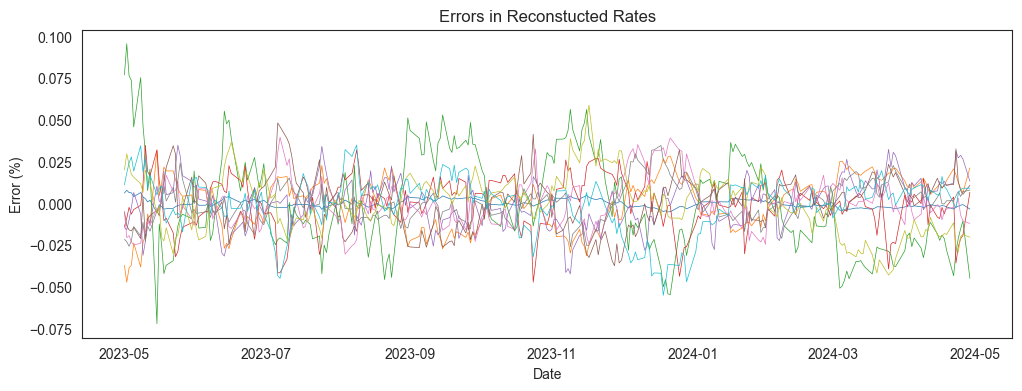

In [17]:
# Reconstruct the standardised interest rates
reconstructed_scaled_rates = np.dot(pc_scores, 
                                    sorted_eig_vectors[:, :4].T)

# Remove standardisation
reconstructed_rates = scaler.inverse_transform(
                        reconstructed_scaled_rates)

print("Principle Component Score Array Shape:\t", pc_scores.shape)

# Plotting before and after PCA
plot_vars = rates.columns
fig, ax = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
plt.suptitle('Comparison of All Rates')
ax[0].plot(rates.index, rates[plot_vars], lw=0.5)
ax[0].set(title='Original Interest Rates', xlabel='Date', 
          ylabel='Interest Rate (%)')

ax[1].plot(rates.index, reconstructed_rates, lw=0.5)
ax[1].set(title='Reconstructed Interest Rates', xlabel='Date')
plt.show()

# Assessing accuracy of recomposition
errors = np.array(rates[plot_vars]) - reconstructed_rates

fig, ax = plt.subplots(figsize=(12,4), ncols=1, nrows=1)
ax.plot(rates.index, errors, lw=0.5)
ax.set(title='Errors in Reconstucted Rates', xlabel='Date', 
       ylabel='Error (%)')
plt.show()

### Simulation

Vasicek short-rate model is used to simulate out the yields. The basic approach is to calibrate kappa, theta and sigma based on a historical dataset and then use it in Monte Carlo modelling of rate paths

In [18]:
def VasicekCalibration(rates, dt=1/252):
    '''
    Calibration function
    '''
    n = len(rates)
    
    Sx = sum(rates.iloc[0:(n-1)])
    Sy = sum(rates.iloc[1:n])
    Sxx = np.dot(rates.iloc[0:(n-1)], rates.iloc[0:(n-1)])
    Sxy = np.dot(rates.iloc[0:(n-1)], rates.iloc[1:n])
    Syy = np.dot(rates.iloc[1:n], rates.iloc[1:n])
    
    theta = (Sy * Sxx - Sx * Sxy) / (n * (Sxx - Sxy) - (Sx**2 - Sx*Sy))
    kappa = -np.log((Sxy - theta * Sx - theta * Sy + n * theta**2) / 
                    (Sxx - 2*theta*Sx + n*theta**2)) / dt
    a = np.exp(-kappa * dt)
    sigmah2 = (Syy - 2*a*Sxy + a**2 * Sxx - 2*theta*(1-a)*(Sy - a*Sx) + 
               n*theta**2 * (1-a)**2) / n
    sigma = np.sqrt(sigmah2*2*kappa / (1-a**2))
    r0 = rates.iloc[n-1]
    
    return [kappa, theta, sigma, r0]

def VasicekNextRate(r, kappa, theta, sigma, dt=1/252):  
    '''
    Simulate next rate
    '''
    val1 = np.exp(-1*kappa*dt)
    val2 = (sigma**2)*(1-val1**2) / (2*kappa)
    out = r*val1 + theta*(1-val1) + (np.sqrt(val2))*np.random.normal()
    return out

def VasicekSim(N, r0, kappa, theta, sigma, dt = 1/252):
    '''
    Simulate single rate path
    '''
    short_r = [0]*N   
    short_r[0] = r0     
    
    for i in range(1,N):
        short_r[i] = VasicekNextRate(short_r[i-1], kappa, theta, sigma, dt)
    
    return short_r

def VasicekMultiSim(M, N, r0, kappa, theta, sigma, dt = 1/252):
    '''
    Simulate multiple rate paths
    '''
    sim_arr = np.ndarray((N, M))
    
    for i in range(0,M):
        sim_arr[:, i] = VasicekSim(N, r0, kappa, theta, sigma, dt)
    
    return sim_arr

In [19]:
loop = 0
for pc in ['PC1','PC2','PC3','PC4']:
    params = VasicekCalibration(rates_pca[pc].dropna())
    
    if loop==0:
        rates_params = pd.DataFrame({'PC':[pc], 
                                     'kappa':[params[0]], 
                                     'theta':[params[1]], 
                                     'sigma': [params[2]]})
        loop += 1
    else:
        tmp = pd.DataFrame({'PC':[pc], 'kappa':[params[0]], 
                            'theta':[params[1]], 'sigma': [params[2]]})
        rates_params = pd.concat([rates_params, tmp], axis=0)
        loop += 1

rates_params = rates_params.set_index('PC')
rates_params

,kappa,theta,sigma
PC,,,
PC1,6.680081,-1.250910,9.112825
PC2,3.669871,-0.141069,3.536190
PC3,39.598986,0.000627,4.814248
PC4,17.294022,-0.004038,1.882033


In [20]:
years = 1
N = years * 252
t = np.arange(0,N)/252
r0 = 0.055
M = 100

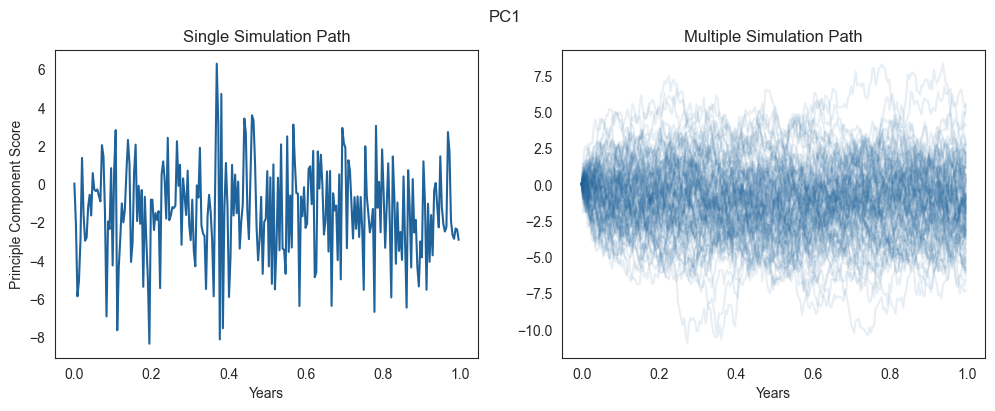

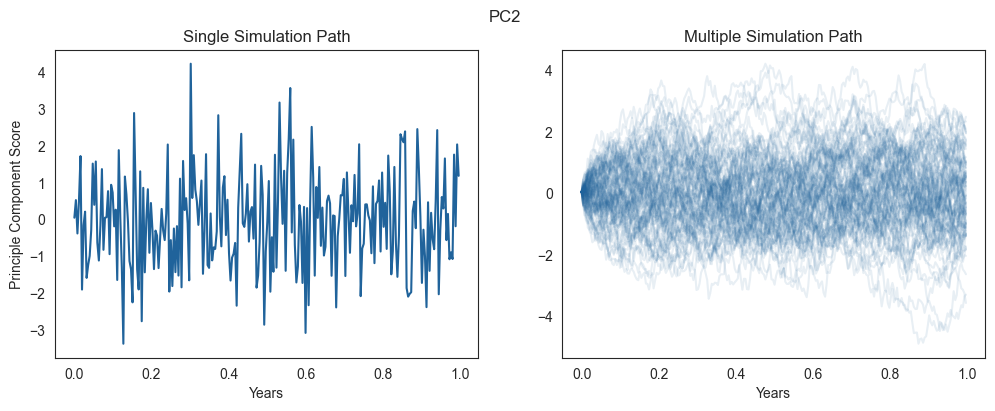

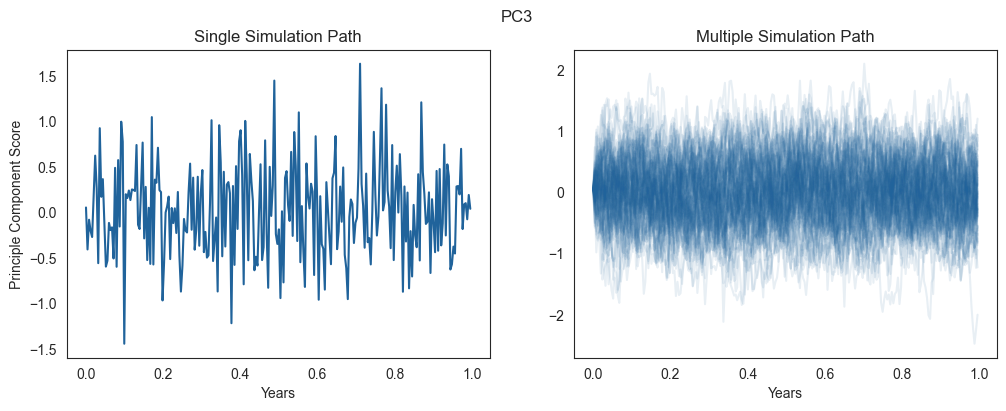

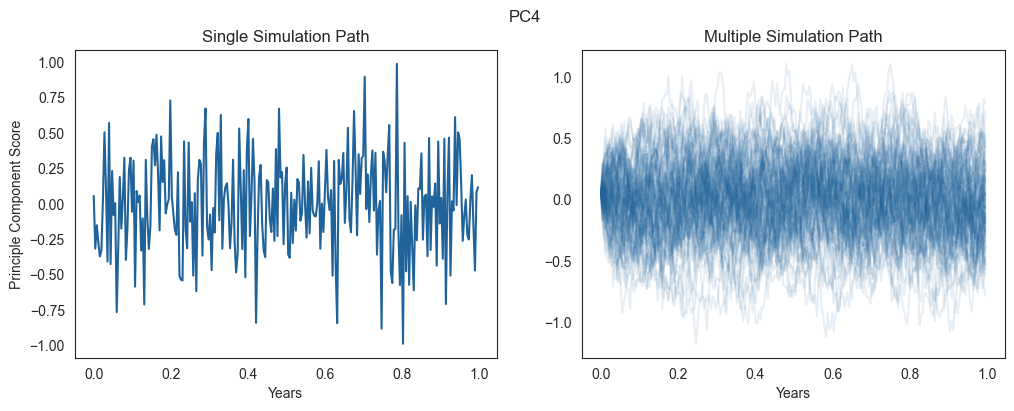

In [21]:
for pc in ['PC1','PC2','PC3','PC4']:
    test_sim = VasicekSim(N, r0, rates_params.loc[pc, 'kappa'], 
                          rates_params.loc[pc, 'theta'], 
                          rates_params.loc[pc, 'sigma'], 1)
    rates_arr = VasicekMultiSim(M, N, r0, 
                                rates_params.loc[pc, 'kappa'], 
                                rates_params.loc[pc, 'theta'], 
                                rates_params.loc[pc, 'sigma'])
    
    fig, ax = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
    plt.suptitle(pc)
    ax[0].plot(t,test_sim, color=c2)
    ax[0].set(title='Single Simulation Path', xlabel='Years', 
              ylabel='Principle Component Score')
    ax[1].plot(t,rates_arr, color=c2, alpha=0.1)
    ax[1].set(title='Multiple Simulation Path', xlabel='Years')
    plt.show()

In [22]:
sim_pc1_arr = VasicekMultiSim(M, N, r0, 
                              rates_params.loc['PC1', 'kappa'], 
                              rates_params.loc['PC1', 'theta'], 
                              rates_params.loc['PC1', 'sigma'])

sim_pc2_arr = VasicekMultiSim(M, N, r0, 
                              rates_params.loc['PC2', 'kappa'], 
                              rates_params.loc['PC2', 'theta'], 
                              rates_params.loc['PC2', 'sigma'])

sim_pc3_arr = VasicekMultiSim(M, N, r0, 
                              rates_params.loc['PC3', 'kappa'], 
                              rates_params.loc['PC3', 'theta'], 
                              rates_params.loc['PC3', 'sigma'])

sim_pc4_arr = VasicekMultiSim(M, N, r0, 
                              rates_params.loc['PC4', 'kappa'], 
                              rates_params.loc['PC4', 'theta'], 
                              rates_params.loc['PC4', 'sigma'])

sim_stack_arr = np.stack((sim_pc1_arr, sim_pc2_arr, sim_pc3_arr, 
                          sim_pc4_arr), axis=1)
print("Shape of PC simulation array:\t", sim_stack_arr.shape)

Shape of PC simulation array:	 (252, 4, 100)


Shape of Interest Rate simulation array:	 (252, 10, 100)


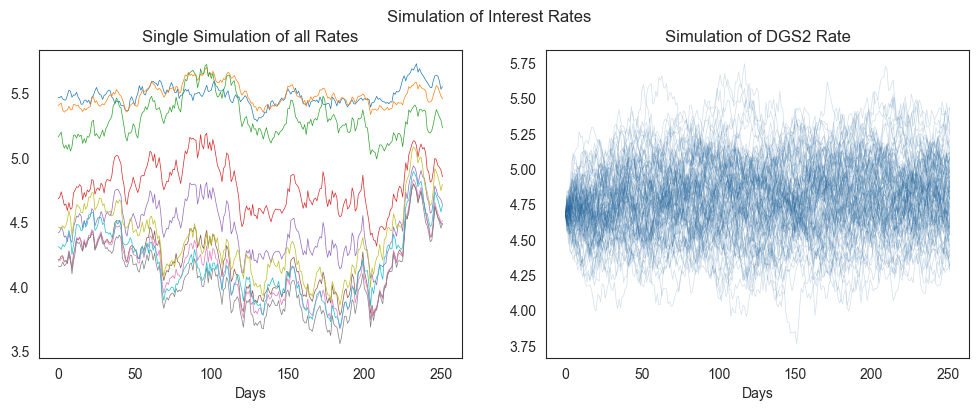

In [23]:
# Reconstruct the interest rates from the simulated principle components
for i in range(M):
    reconstructed_scaled_rates = np.dot(sim_stack_arr[:,:,i], 
                                        sorted_eig_vectors[:, :4].T)
    reconstructed_rates = scaler.inverse_transform(
                            reconstructed_scaled_rates)

    if i == 0:
        rates_sims = reconstructed_rates 
    else:
        rates_sims = np.dstack((rates_sims, reconstructed_rates))

print("Shape of Interest Rate simulation array:\t", rates_sims.shape)

# Plotting the simulated interest rates
plot_vars = rates.columns
fig, ax = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
plt.suptitle('Simulation of Interest Rates')

ax[0].plot(reconstructed_rates, lw=0.5)
ax[0].set(title='Single Simulation of all Rates', xlabel='Days')

ax[1].plot(rates_sims[:,3,:], color=c2, alpha=0.2, lw=0.5)
ax[1].set(title='Simulation of {} Rate'.format(plot_vars[3]), 
          xlabel='Days')
plt.show()